In [ ]:
import torch
import os
import json
import string
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.display import HTML, display

from sympy.combinatorics import CyclicGroup, DihedralGroup

from src.load_utils import load_gpt, load_task

In [ ]:
dirname = '../outputs/mixrosette-facts-10-16-8heads'

gpt = load_gpt(dirname).cuda()
task, task_name = load_task(dirname)

import nnsight
model = nnsight.NNsight(gpt)

number of parameters: 50.42M
iteration: inf
Trained on mixrosette up to order 10 with 16 symbols


#### Copying Scores

In [4]:
from tqdm import tqdm 
from src.data_utils import sample_copy_counterfactual_pair   
from src.intervention_utils import attn_head_intervention_sweep

import matplotlib.pyplot as plt
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_copy_scores(copy_scores, cmap='Greens', save_path=None):
    """
    """
    # Configure matplotlib to use Times New Roman with larger default size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.size'] = 18  # Base font size

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(copy_scores.mean(-1), cmap=cmap, vmin=0, vmax=1)
    ax.set_ylabel(f"Layer")
    ax.set_xlabel(f"Head Index")
    plt.yticks(range(4), range(4))
    plt.xticks(range(8), range(8))

    # Create an axes on the right for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size & padding

    # Create colorbar
    cbar = plt.colorbar(im, cax=cax)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


def attention_head_patching_copy_scores(model, task, copy_distribution='copy', N_sequences=200, K_shots=200):
    """
    """
    assert copy_distribution in ['copy', 'commute', 'test']

    copy_scores = []
    
    for i in tqdm(range(N_sequences), total=N_sequences):
        sequence, sequence_2, vocabulary, vocabulary_2 = sample_copy_counterfactual_pair(task, k_shots=K_shots, copy_distribution=copy_distribution, unshuffled=False)
        
        scores, inputs_1, targets_1, inputs_2, targets_2 = attn_head_intervention_sweep(model, task, sequence, sequence_2, True)

        copy_scores.append(scores[:,:,targets_1[:,-1]].squeeze())

    all_copy_scores = torch.stack(copy_scores, dim=-1)

    return all_copy_scores

In [ ]:
all_copy_scores = attention_head_patching_copy_scores(model, task, copy_distribution='copy', N_sequences=200, K_shots=200)
all_commute_copy_scores = attention_head_patching_copy_scores(model, task, copy_distribution='commute', N_sequences=200, K_shots=200)
all_no_copy_scores = attention_head_patching_copy_scores(model, task, copy_distribution='test', N_sequences=200, K_shots=200)

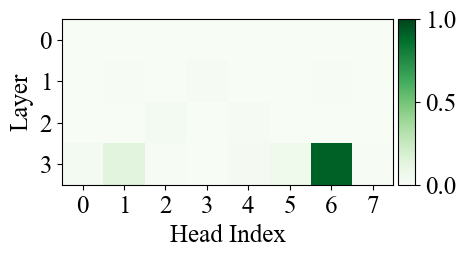

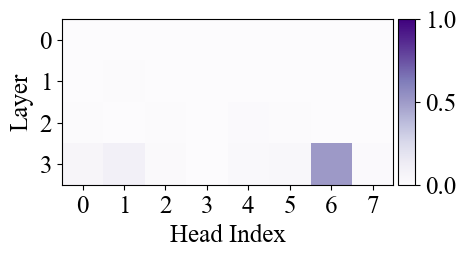

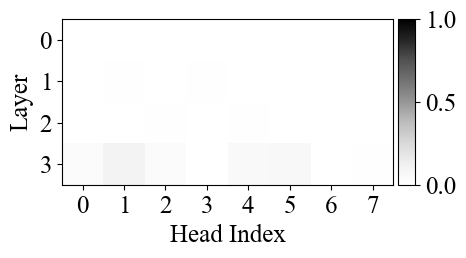

In [ ]:
plot_copy_scores(all_copy_scores, cmap='Greens', save_path=None)
# plot_copy_scores(all_copy_scores, save_path='patching_copy_score.pdf')

plot_copy_scores(all_commute_copy_scores, cmap='Purples', save_path=None)
# plot_copy_scores(all_commute_copy_scores, save_path='patching_commute_copy_score.pdf')

plot_copy_scores(all_no_copy_scores, cmap='Grays', save_path=None)
# plot_copy_scores(all_no_copy_scores, save_path='patching_no_copy_score.pdf')

#### Behavior of Heads Under Cyclic, Dihedral, and No-Copy Settings:

In [ ]:
from src.intervention_utils import head_output_to_vocab
import random

def attention_copy_decoding(model, task, group_type='cyclic', N_sequences=200, K_shots=200, layer_index=3):
    """
    """
    assert group_type in ['cyclic', 'dihedral']   

    copy = []
    no_copy = []
    commute_copy = []    

    for H in range(model.config.n_head):
        check_seen = []
        check_unseen = []
        check_reverse = []

        head = (layer_index,H)

        for i in range(N_sequences):
            if group_type == 'cyclic':
                order = random.randint(3,10)
                group = CyclicGroup(order)
                sequence, sequence_2, _, _ = sample_copy_counterfactual_pair(task, k_shots=K_shots, copy_distribution='copy', unshuffled=False, fixed_groups=[group])
                
            elif group_type == 'dihedral':
                order = random.choice([3,4,5])
                group = DihedralGroup(order)
                sequence, sequence_2, _,_ = sample_copy_counterfactual_pair(task, k_shots=K_shots, copy_distribution='copy', unshuffled=False, fixed_groups=[group], flipped_query=True)

            tensor_1 = task.tensor_from_expression([sequence])
            tensor_2 = task.tensor_from_expression([sequence_2])
            inputs_1, targets_1 = tensor_1[:, :-1], tensor_1[:, 1:]
            inputs_2, targets_2 = tensor_2[:, :-1], tensor_2[:, 1:]
        
            promoted  = head_output_to_vocab(model, inputs_1, head)
            promoted_2 = head_output_to_vocab(model, inputs_2, head)
            check_seen.append(targets_1[:,-1].item() == promoted.topk(1).indices.item())
            check_unseen.append(targets_2[:,-1].item() == promoted_2.topk(1).indices.item())

            if group_type == 'cyclic':
                sequence_3, _, _, _ = sample_copy_counterfactual_pair(task, k_shots=K_shots, copy_distribution='commute', unshuffled=False, fixed_groups=[group])
                tensor_3 = task.tensor_from_expression([sequence_3])
                inputs_3, targets_3 = tensor_3[:, :-1], tensor_3[:, 1:]
                promoted_3 = head_output_to_vocab(model, inputs_3, head)
                check_reverse.append(targets_3[:,-1].item() == promoted_3.topk(1).indices.item())

            elif group_type == 'dihedral':
                check_reverse.append(targets_1[:,-1].item() == promoted_2.topk(1).indices.item())
                
        copy.append(sum(check_seen)/len(check_seen))
        no_copy.append(sum(check_unseen)/len(check_unseen))
        commute_copy.append(sum(check_reverse)/len(check_reverse))
            
    return copy, commute_copy, no_copy
        

print("Cyclic Groups:")
copy_behavior_cyclic, commute_copy_behavior_cyclic, no_copy_behavior_cyclic = attention_copy_decoding(model, task, 'cyclic',200, 200)

print("\nDihedral Groups:")
copy_behavior_dihedral, commute_copy_behavior_dihedral, commute_copy_match_behavior_dihedral = attention_copy_decoding(model, task, 'dihedral',200, 200)

Cyclic Groups:

Dihedral Groups:


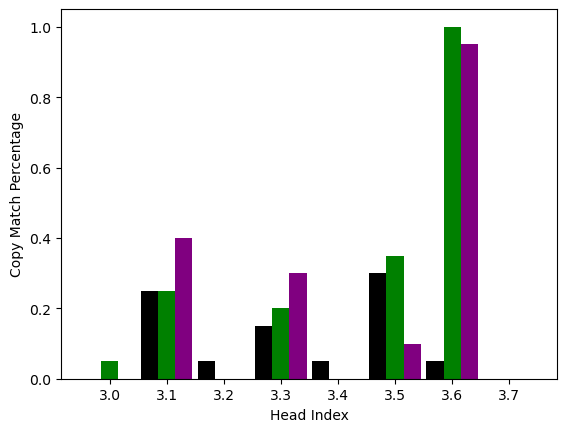

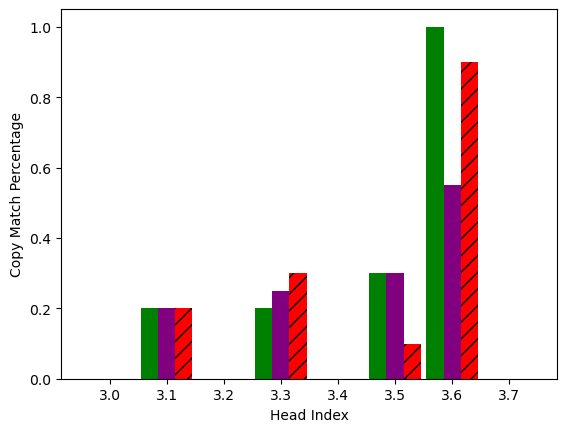

In [48]:
import torch
import matplotlib.pyplot as plt


####
# Cyclic Plot
####

width = 0.3  # Adjust the width of bars
x = torch.arange(model.config.n_head)  # Create x positions

plt.bar(x - width, no_copy_behavior_cyclic, width=width, label='Not Copyable', color='Black')
plt.bar(x, copy_behavior_cyclic, width=width, label='Exact Copyable', color='green')
plt.bar(x+ width, commute_copy_behavior_cyclic, width=width, label='Reverse Copyable', color='purple')

plt.ylabel("Copy Match Percentage")
plt.xlabel("Head Index")
plt.xticks(x.tolist(), [f'3.{i}' for i in range(model.config.n_head)])

# plt.savefig(f'copy_match_percent_cyclic.pdf', bbox_inches='tight')
plt.show()


####
# Dihedral Plot
####

width = 0.3  # Adjust the width of bars
x = torch.arange(model.config.n_head)  # Create x positions

plt.bar(x-width, copy_behavior_dihedral, width=width, label='Exact Pair Seen', color='green')
plt.bar(x, commute_copy_behavior_dihedral, width=width, label='Reverse Pair Seen', color='purple')
plt.bar(x+width, commute_copy_match_behavior_dihedral, width=width, label='Reverse Pair Seen', color='red', hatch='//')

plt.ylabel(r"Copy Match Percentage")
plt.xlabel("Head Index")
plt.xticks(x.tolist(), [f'3.{i}' for i in range(model.config.n_head)])

# plt.savefig(f'copy_match_percent_dihedral.pdf', bbox_inches='tight')

plt.show()